<a href="https://colab.research.google.com/github/hmobley/liveproject_water/blob/master/Part3_SegImages_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification (Manning Publications)</span><br/>by <em>Daniel Buscombe</em> </strong><br/><br/>
        <strong>> Chapter 3: Image Segmentation Models </strong><br/>
    </p>           

<p style="border: 1px solid #182AEB; border-left: 15px solid #182AEB; padding: 10px; text-align:justify;">
    <strong style="color: #182AEB">What you learned in Part 2.</strong>  
    <br/>In Part 2, you developed a number of datasets to train and test segmentation models: <br/> 1) An image set consisting of time-series of cloudless sentinel-2 imagery at a number of lakes undergoing change; <br/> 2) A subset of representative sample images and a corresponding label image set and label images for each sample image; <br/> 3) An image set consisting of NWPU-RESISC45 data consisting of 700-example satellite images each of 45 land cover/use classes, including lakes; and <br/> 4) A representative subset of NWPU-RESISC45 lake images and a corresponding label image set.
    </p>
    
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">What you will learn in this Part.</strong>  
    <br/>In Part 3, you will first learn how to create image generators, and how to create an augmented data set of the above images and labels, consisting of the original set plus a set of randomly generated versions of the originals that have been transformed in some way. Then, you will learn how to build the deep convolutional autoencoder-decoder “U-Net” model to perform semantic segmentation of imagery. 
    </p>    

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Introduction to <br/> Google Colab</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
When open in colaboratory, go to **Runtime** on the toolbar, then **Change runtime type**, and finally under **Hardware accelerator*** select **GPU** and hit **Save**. 

This will allow you to train models using a GPU, which is a necessity if you want model training to complete in a reasonable time. 
</p>
<p style="border-left: 15px solid #6019D6; padding: 0 10px; text-align:justify;">
    <strong style="color: #6019D6;">Tip.</strong> 
The following experiments are compute-heavy (large model and dataset). Make sure the procedures are performed on GPU(s)
</p>
        </tr>
        </table>

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Preparing datasets for <br/> a deep learning project</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
This Part introduces several ways to generate satellite imagery and associated labels that you can use in your deliverables. We will use these data to perform a semantic segmentation of imagery to identify water pixels. Semantic segmentation is a type of <b>classification</b> algorithm.
    In machine (deep) learning with imagery, a classification algorithm is usually one that is used to answer binary yes-or-no questions (e.g. "Does this image contain water?") or a multiclass classification ("Which of the following is in this image: water, grass, trees?"). Supervised classification is when you also provide the right answers or `labels', so an algorithm can learn from them. In semantic segmentation, each pixel is classified so labels are images where each pixel is a code that corresponds to a particular class. In our binary segmentation task, label images are composed of 1 for water and 0 for everything else. 
 
</p>
<p style="border-left: 15px solid #6019D6; padding: 0 10px; text-align:justify;">
    <strong style="color: #6019D6;">Tip.</strong> 
    <a href="https://machinelearningmastery.com/difference-test-validation-datasets/">Read this guide to dataset splits:</a>
<ul>
  <li>Training dataset: The dataset that we use to train the model (weights and biases of the neural network). The model sees and learns from this data.</li>    
  <li>Test dataset: The dataset that is used to evaluate the final trained model.</li>
</ul>    
</p>
        </tr>
        </table>

#### Copying the data: Colab users

Import tensorflow, check the version, and make sure you have a GPU at your disposal

Uncomment and run the cell below to ensure you have TensorFlow 2 installed on you colab environment (if that is how you are running this notebook)

In [2]:
#colab = 0
colab = 1

In [ ]:
if colab==1:
    !pip install --default-timeout=1000 tensorflow-gpu==2.0

You may have to restart the runtime and/or change runtime type here, if the following doesn't show Tensorflow version 2, and a GPU available

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.3.0'

In [5]:
if colab == 1:
  print(tf.config.list_physical_devices('GPU'))
else:
  print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


If you are running this notebook on Colab, you may find the following workflow convenient, whereby images and labels are downloaded from google drive an unzipped, like we saw in Part 1

In [6]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

Uncomment the ```download_file_from_google_drive``` to actually download the zipped files into Colab

In [7]:
#imagery
file_id = '1iMfIjr_ul49Ghs2ewazjCt8HMPfhY47h'
destination = 's2cloudless_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

In [8]:
#labels
file_id = '1c7MpwKVejoUuW9F2UaF_vps8Vq2RZRfR'
destination = 's2cloudless_label_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

In [9]:
import zipfile
def unzip(f):
    """
    f = file to be unzipped
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()

Again, for Colab users, uncomment the unzip commands

In [10]:
if colab==1:
    unzip('s2cloudless_imagery.zip')
    unzip('s2cloudless_label_imagery.zip')

In [21]:
ls

all_labels.json       s2cloudless_imagery.zip     s2cloudless_label_imagery.zip
s2cloudless_imagery/  s2cloudless_label_imagery/  sample_data/


##### Other users (local desktop/laptop)

Copy the ```s2cloudless_imagery``` directory over from ```2_Data```

In [ ]:
if colab!=1:
    import shutil, os
    shutil.copytree('..'+os.sep+'2_Data'+os.sep+'s2cloudless_imagery', 's2cloudless_imagery')

Copy the ```s2cloudless_label_imagery``` directory over from ```2_Solution```

In [ ]:
if colab!=1:
    shutil.copytree('..'+os.sep+'2_Solution'+os.sep+'s2cloudless_label_imagery', 's2cloudless_label_imagery')

Finally, copy over the labels json file

In [ ]:
if colab!=1:
    shutil.copy('..'+os.sep+'2_Data'+os.sep+'s2cloudless_labels'+os.sep+'all_labels.json', 'all_labels.json')

Optionally, you could now delete the original directories to save space

#### Image Generator Functions

When training machine learning models on large data sets, it is often optimal to generate your dataset in real time and feed it right away to your deep learning model while it is training.

We do that using generators. Read up on generators in python [here](https://realpython.com/introduction-to-python-generators/). The generator will _generate_ a batch of random images and associated masks, which is fed to the neural network at the start of a training epoch. Much more about training in the next Part. For now, we're concerned only with making that generator function. 

In [12]:
from PIL import Image, ImageDraw
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json, os, glob

The next function creates a generator that will randomly draw images from the training and testing sets. The inputs:

* files = list of image files
* batch_size = 32 = number of images (plus corresponding labels) to use in each batch 
* sz = (512, 512) = image size to use. Typically we want relatively small images for computational efficiency

In [13]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f's2cloudless_imagery/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('s2cloudless_imagery','s2cloudless_label_imagery')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>100).astype('int')
        
        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

Get a list of images and labels

Colab users, you will need to quickly upload your copy of ```all_labels.json``` here

In [22]:
#if colab == 1:
#  file_id = '1Zz7scOC5rc8VmO1_vx7BzCJP0BjHH9mX'
#  destination = 'all_labels.json'
#  download_file_from_google_drive(file_id, destination)

In [15]:
# Very tedious to have to do this every time I run, but could not
# get above code to work. Some issue with the decoding that I will
# need to investigate someday.
if colab == 1:
  from google.colab import files
  uploaded = files.upload()
  data = json.loads(uploaded['all_labels.json'].decode("utf-8"))
else:
  data = json.load(open('all_labels.json'))

Saving all_labels.json to all_labels (1).json


In [16]:
# get a sorted list of image filenames, which are the 'keys' of the dictionary object
images = sorted(data.keys())
#data.keys()

In [22]:
%ls
#rm all_labels\ \(1\).json

all_labels.json       s2cloudless_imagery.zip     s2cloudless_label_imagery.zip
s2cloudless_imagery/  s2cloudless_label_imagery/  sample_data/


In [23]:
# use glob to find all jpg files in the imagery folder
labels = sorted(glob.glob('s2cloudless_label_imagery'+os.sep+'data'+os.sep+'*.jpg'))
# remove the subdirectory suffix from each label
labels = [l.split(os.sep)[-1] for l in labels]

#### Setting up model training hyperparameters

Next we set our batch size (number of images to pass to each model training epoch, 5), and the proportion of all images to use for training (0.5, or 50%)

In [24]:
batch_size = 5
prop_train = 0.5

We define train and test splits simply as the first and second halves:

In [25]:
split = int(prop_train * len(images))

#split into training and testing
train_files = images[0:split]
test_files  = images[split:]

The next few lines randomly select a few images and display them and their associated masks, and the resulting masked images. 

In [26]:
train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)

To access the ```next``` pair of image and label from the generator:

In [27]:
x, y= next(train_generator)

Make a function to generate an image for display, composed of the original image, binary mask, and masked image side-by-side

In [28]:
def get_pair(i):
    img = x[i]
    msk = y[i].squeeze()
    msk = np.stack((msk,)*3, axis=-1)
    return np.concatenate([img, msk, img*msk], axis = 1)

Show the first five images

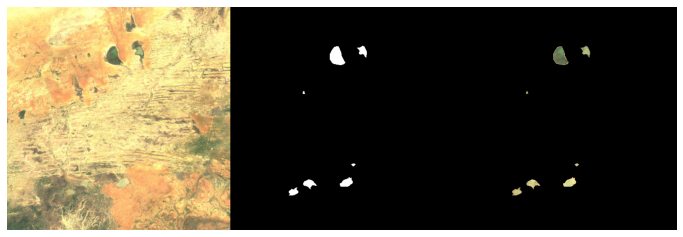

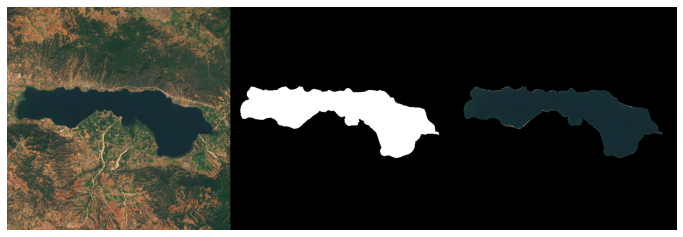

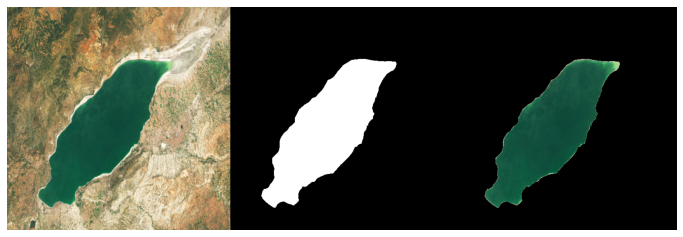

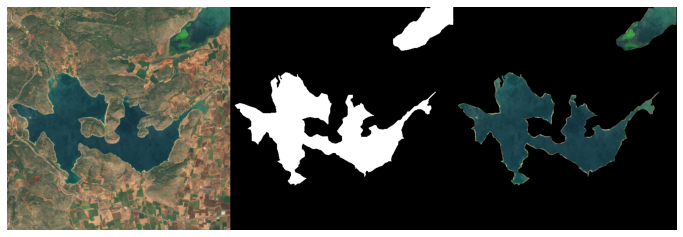

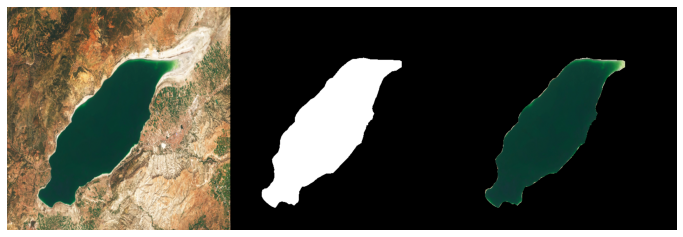

In [29]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(0))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(1))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(2))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(3))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(4))

in the next Part, you will see how we can use the ```image_batch_generator``` function above to get separate generators for training and testing subsets of the data, and pass each generator to a keras model training session. Given a ```batch_size``` and list of ```test``` and ```train``` filenames

In [30]:
train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Image augmentation</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
Deep learning models usually need a lot of data to be properly trained. It is often useful to get more data from the existing ones using data augmentation techniques. The main ones are summed up in the table below. More precisely, given the following input image, here are some of the techniques that we can apply:

* Flip (horizontal or vertical).
* Rotation. 
* Brightness.  
* Information loss
* Random cropping (subsets of images)
* Contrast
* Random zoom
* etc

</p>
        </tr>
        </table>

For consistency with previous Parts we will again use rasterio to read in image files

In [31]:
if colab==1:
    !pip install rasterio

     |████████████████████████████████| 18.3MB 171kB/s 


In [32]:
import json, os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt

#### Principles and rationale of data augmentation and augmenting imagery with keras/Tensorflow 2

The keras ```ImageDataGenerator``` function is extremely useful for implementing several common image augmentation strategies, for example the below would randomly apply zoom, shear, rotation, shifts, and requantization of the imagery 

In [33]:
im_gen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True, 
samplewise_std_normalization=True, 
horizontal_flip = False, 
vertical_flip = False, 
height_shift_range = 0.1, 
width_shift_range = 0.1, 
rotation_range = 10, 
shear_range = 0.05,
fill_mode = 'reflect', #'nearest',
zoom_range= 0.2)

The above would apply only to one set of images, whereas we want to apply the same set of image transformations on both our images and the masks. A convenient way to do so is to create a dictionary of desired augmentations and pass to separate generators

In [34]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

#### Creating and merging image and mask generator functions

In order to use an image generator you need to specify how information flows through it, or where the data is read from. We want to read imagery from directories of files, so the appropriate ```flow``` type to use is ```flow_from_directory```.

Below is a fully worked example that creates generators that randomly apply up to 90 degree rotations and horizontal flips. The ```flow_from_directory``` for each specifies no random shuffling, which is important to ensure that images and labels correspond with one another. The images are also read in as 512 x 512 pixels, and the batch size is the entire data set (i.e. ```len(all_images)```)

In [35]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0,
        zoom_range=0,
        rotation_range=90,
        horizontal_flip=True)

img_generator = train_datagen.flow_from_directory(
        's2cloudless_imagery',
        target_size=(512, 512),
        batch_size=len(images),
        class_mode=None, seed=111, shuffle=False)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,    
        shear_range=0,
        zoom_range=0,
        rotation_range=90,
        horizontal_flip=True)

mask_generator = test_datagen.flow_from_directory(
        's2cloudless_label_imagery',
        target_size=(512, 512),
        batch_size=len(images),
        class_mode=None, seed=111, shuffle=False)

Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


The following merges the two generators (and their flows) together:

In [36]:
train_generator = (pair for pair in zip(img_generator, mask_generator))

#### Create and visualize arbitrary transformations to input imagery

To access the ```next``` pair of image and label from the generator:

In [37]:
x, y = next(train_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Take a look at the size and length of the data

In [38]:
np.shape(np.max(y[10], axis=2))

(512, 512)

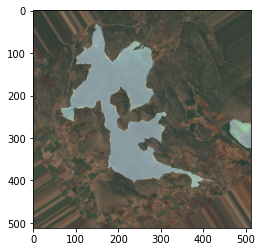

In [39]:
%matplotlib inline
plt.imshow((x[10]).astype('uint8'), cmap='gray') #show the 10th image
plt.imshow(np.max(y[10], axis=2)/255, cmap='gray', alpha=0.5) #show the 10th label as an alpha mask

A little more visually appealing is a figure with alpha channels appropriately set, like we did above

In [40]:
def get_pair(i):
    img = x[i].astype('uint8')/255
    msk = np.max(y[i], axis=2)/255
    msk[msk>=.5]  = 1
    msk[msk<.5] = 0
    msk = np.stack((msk,)*3, axis=-1)
    return np.concatenate([img, msk], axis = 1)

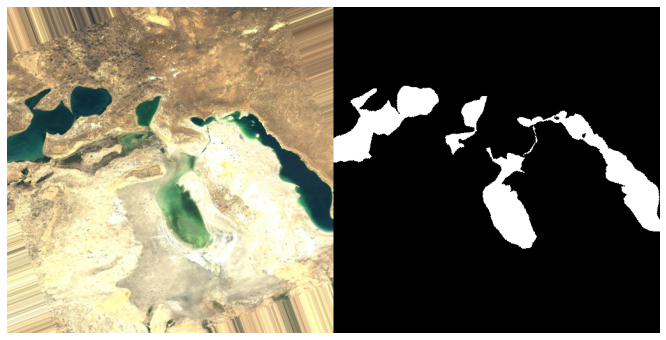

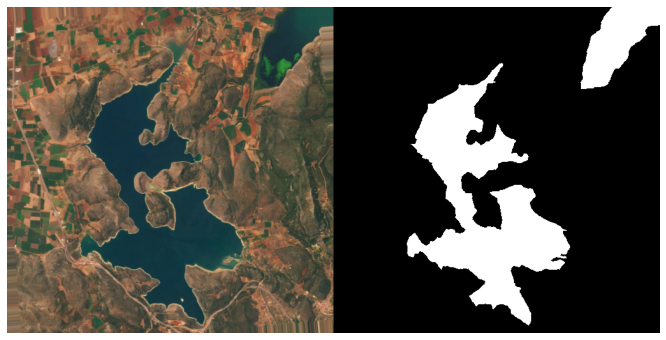

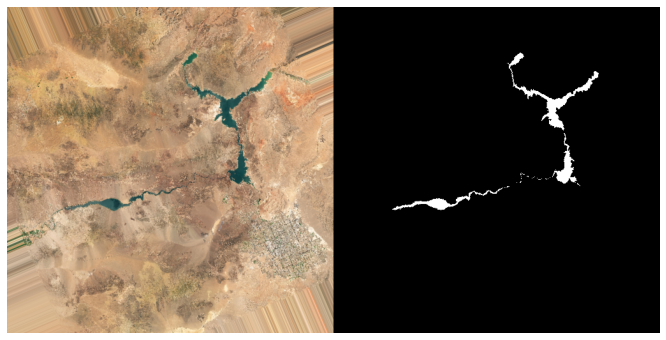

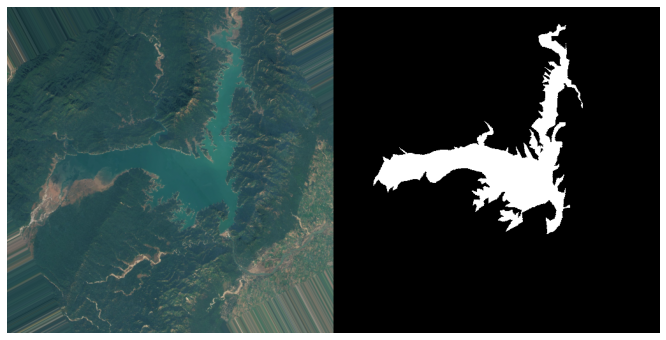

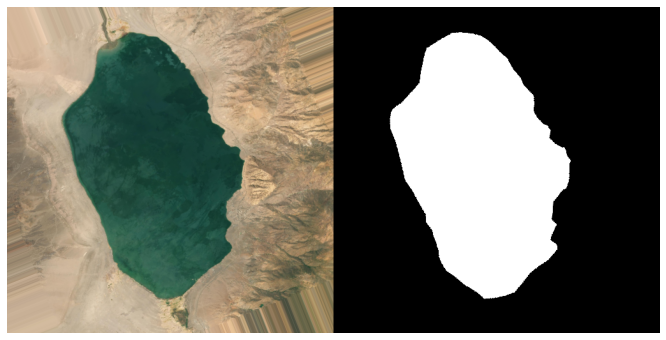

In [41]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(0))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(9))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(19))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(29))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(39))

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>A brief introduction to <br/> Convolutional Neural Networks</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
    Here we explore in a little more detail convolutional neural networks, also known as <b>CNNs</b>, which are a specific type of neural networks used extensive in deep learning classification (and regression) tasks
        </tr>
        </table>

##### Basic principles

* Convolutional Neural Networks (CNNs) are very similar to ordinary Neural Networks: they are made up of neurons that have learnable weights and biases.

* CNN architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture.

Natural images exhibit ”‘stationarity”’, meaning that the statistics of one part of the image are the same as any other part. This suggests that the features that we learn at one part of the image can also be applied to other parts of the image, and we can use the same features at all locations.

More precisely, having learned features over small (say 8x8) patches sampled randomly from the larger image, we can then apply this learned 8x8 feature detector anywhere in the image. Specifically, we can take the learned 8x8 features and ”‘convolve”’ them with the larger image, thus obtaining a different feature activation value at each location in the image.

#### Layers

The layers consist of hierarchical filters that are designed to extract features of increasingly complexity

* The input of each layer is the output of the previous one

* The layer does not need to learn the whole concept at once, but actually build a chain of features that build that knowledge.

* It learns the best way to map inputs to outputs (you don’t need to)


![](https://i1.wp.com/www.michaelchimenti.com/wp-content/uploads/2017/11/Deep-Neural-Network-What-is-Deep-Learning-Edureka.png)

To demonstrate some principles we will load an image, convert it to a tensor

In [42]:
%matplotlib inline
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import rasterio, os
import numpy as np

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


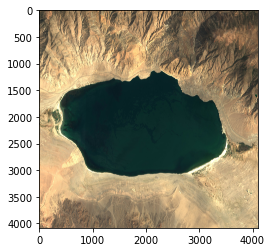

In [43]:
with rasterio.open('s2cloudless_imagery'+os.sep+'data'+os.sep+'walker_s2cloudless-2016.jpg') as dataset:
    image = np.array(dataset.read().T)

plt.imshow(image)

In [44]:
image = tf.image.rgb_to_grayscale(tf.image.resize(image, (128,128)) )   

To use this image with TensorFlow, we convert it into a `Tensor`. Many Tensorflow operations we will use in this project are meant for batches of images, i.e., of shape $(N, H, W, C)$ where $N$ is the number of images, $H$ and $W$ are height and width, and $C$ is the number of channels (3 = RGB, 1 = grayscale)

Exapnd the dimensions of our image, and turn it into a batch consisting of just one image

In [45]:
image = tf.convert_to_tensor(image, tf.float32, name="input_image")
image = tf.expand_dims(image, axis=0) 

In [46]:
print("Tensor shape: {}".format(image.shape))

Tensor shape: (1, 128, 128, 1)


#### Types of layers

CNNs are generally composed of the following layers:

![](https://stanford.edu/~shervine/images/architecture-cnn.png)
[source](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

##### Convolution layer (CONV)

[source](http://deeplearning.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/)

The convolution layer (CONV) uses filters that perform convolution operations as it is scanning the input with respect to its dimensions. Its hyperparameters include the filter size and stride length. The resulting output is called feature map or activation map.

![](https://stanford.edu/~shervine/images/convolution-layer-a.png)

In [48]:
# define a Guassian blur filter
a = np.zeros([3, 3, 1, 1])
a[1, 1, :, :] = 0.25
a[0, 1, :, :] = 0.125
a[1, 0, :, :] = 0.125
a[2, 1, :, :] = 0.125
a[1, 2, :, :] = 0.125
a[0, 0, :, :] = 0.0625
a[0, 2, :, :] = 0.0625
a[2, 0, :, :] = 0.0625
a[2, 2, :, :] = 0.0625

To pass the tensor to the convolution algorithm we can actually convert $(N, H, W, C)$ to $(N, C, H, W)$ then provide the argument ```data_format = 'NCHW'```

In [49]:
# reshape data 
proj = np.array(image).reshape(1,1,128,128)

# convolve with filter
proj = tf.nn.conv2d(
    proj, a,
    strides = [ 1, 1, 1, 1 ],
    padding = 'SAME',
    data_format = 'NCHW'
)

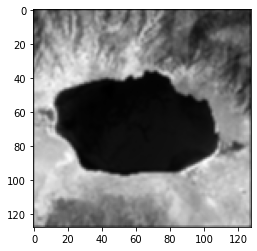

In [50]:
# display convolved image
plt.imshow(np.squeeze(proj), cmap='gray')

The `tf.nn.conv2d` layer is the backend to the keras `Conv2D` layer that we'll make repeated use of in this project, so it's worth spending some time getting to know its arguments:

* `strides` is a list of 4 integers that defines the stride to take (how many pixels to shift in each of the 4 dimensions) for the kernel during the convolution operation

* `padding` This is the instruction of what the convolution algorithm should do at the boundary of the data. It can be a specific padding dimension in pixels but more typically `SAME` and `VALID` are used. `VALID` means no padding (the filters slide only the _valid_ pixels not too near the boundary) and `SAME` means it will enforce the outputs to be the same as the inputs by temporarily setting the stride length to fit evenly at the boundary

Convolutions like this are at the center of deep learning and convolutional neural networks. Their repeated application, with pooling layers, distill the relevant information in the image for the task.

##### Pooling (POOL)

The pooling layer (POOL) is a downsampling operation, typically applied after a convolution layer, which does some spatial invariance. In particular, max and average pooling are special kinds of pooling where the maximum and average value is taken, respectively.

![](https://stanford.edu/~shervine/images/max-pooling-a.png)
[source](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

For ***max-pooling*** and ***average-pooling***, the values in each window are aggregated into a single output, applying respectively the max or averaging operation. 

Apply the average pooling operator with stride lengths of 1, 1, 2, and 2 for, respectively, the $(N, C, H, W)$ dimensions, meaning the pooled image will be half the size in $H$ and $W$

The code below uses a kernel size of 16 pixels in the $H$ dimension, which will result in vertical smearing of the image

In [51]:
avg_pooled_image = tf.nn.avg_pool(proj, ksize=[1, 1, 16, 1], strides=[1, 1, 1, 2], padding="SAME")

In [52]:
avg_res = avg_pooled_image.numpy() #eager execution allows direct conversion to numpy array
np.shape(avg_res) # get shape of the array

(1, 1, 128, 128)

We used a kernel size of 16 pixels in the $H$ dimension, therefore the result is a pooled image that is smoothed vertically but not horizontally 

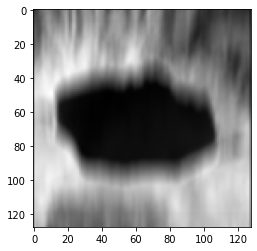

In [53]:
plt.imshow(np.squeeze(avg_res), cmap=plt.cm.gray)

##### Fully Connected (FC)

The fully connected layer (FC) operates on a flattened input where each input is connected to all neurons. If present, FC layers are usually found towards the end of CNN architectures and can be used to convert multidimensional features into a 1d vector of class scores.

![](https://stanford.edu/~shervine/images/fully-connected.png)
[source](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Introduction to <br/> Auto-encoder networks</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
Autoencoders receive input data (image), encode it, then returns the same data on the output layer. They are kind of neural network that take an image and compress the information in it to a linear feature representation (vector) or "code". The "code" is upsampled by the decoder portion of the auto-encoder, called the "decryption" layer. The architecture preserves the dimensionality of input->output. But, the linear compression of the input leads to a bottleneck that does not transmit all features.  

Below we will make a deep autoencoder that creates outputs from extremely compressed inputs, which could be used for image denoising.
  
</p>
<p style="border-left: 15px solid #6019D6; padding: 0 10px; text-align:justify;">
    <strong style="color: #6019D6;">Tip.</strong> 
We can have more than one hidden layers and than we have so-called Deep Autoencoders. The U-Net and FCN models we will use later are two different types of deep autoencoders modified for for semantic segmentation.
</p>
        </tr>
        </table>

##### Preparing the dataset

Read each image and keep track of the minimum dimension of all images (later all images will be cropped to this square dimension)

In [54]:
import rasterio, json, os
import numpy as np

# load the labels than contain the image list
data = json.load(open('all_labels.json'))
images = sorted(data.keys())

# pre-allocate arrays for images and minimum dimensions
all_images = []; N = []
for image in images: # loop through each image file
    with rasterio.open('s2cloudless_imagery'+os.sep+'data'+os.sep+image) as dataset:
        tmp = np.squeeze(np.array(dataset.read().T)) #read the data and transpose
        nx, ny, _ = np.shape(tmp) # get the dimensions
        n = np.minimum(nx,ny) # get the minimum dimension
        all_images.append(tmp) # append the image
        N.append(n) #append the min dimension

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Crop all images to the same minimum square extent

In [55]:
n = np.min(N) # get the global minimum dimension
all_images = [l[:n,:n] for l in all_images] # crop all images to that square dimension
all_images = np.array(all_images) # convert list to a numpy array

Check the shapes ($N$, $H$, $W$, $C$):

In [56]:
print(all_images.shape)

(40, 2312, 2312, 3)


Define an output image size

In [57]:
IMG_SIZE = 124

Resize each image and keep only the first (red) band

In [58]:
#import tensorflow as tf
all_images2 = np.zeros((40,IMG_SIZE,IMG_SIZE))
counter = 0
for k in all_images:
    all_images2[counter,:,:] = np.squeeze(tf.image.resize(k, (IMG_SIZE,IMG_SIZE), method='nearest'))[:,:,0]
    counter += 1

Let's take a look at an image

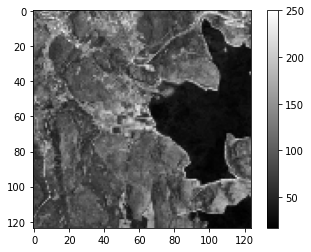

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(all_images2[10].astype('uint8'), cmap='gray')
plt.colorbar()

Use the first 30 images for training and the last 10 for testing

In [60]:
x_train = all_images2[:30,:,:]
x_test = all_images2[30:,:,:]

Check the shapes

In [61]:
print(x_train.shape)
print(x_test.shape)

(30, 124, 124)
(10, 124, 124)


We no longer need ```all_images```

In [62]:
del all_images

Import the necessary layers and ```Model``` structure from keras

In [63]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

##### Theory in action: Auto-encoding

The following class carries out training and prediction for a deep convolutional autoencoder. The 'encoding' part uses 3 blocks of convolutional filters and 2 max pooling layers for 'auto'mated feature extraction. The feature vector, or 'code', is then upscaled using the reverse sequence of operations in the encoding part. Training is then used to optimize the weights of all the convolutional filters.

This is exactly how we will later use deep autoencoder models for semantic segmentation. This exercise is designed to introduce you to the basic building blocks and concepts of the encoding-decoding concept.

The goal in the following lines of code is to properly encode then decode an image wihout impacting the quality, despite the so-called _bottleneck_ which is the 'code' or low-dimesional feature representation. The bottleneck forces the model to learn a properly compressed representation of the salient image features extracted by the network 

In [64]:
# make a python class 
class Deep_Autoencoder():
    
    def __init__(self):    
        
        ## the Encoding part
        # use grayscale only so W x H x 1
        in_ = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
        # 2d convolution layer with 32 output filters in the convolution, 
        # 3x3 pixel kernel, and Relu activation
        _ = Conv2D(32, (3, 3), activation='relu', padding='same')(in_)
        #'_' is being used as a intermediate variable that is overwritten in each layer
        _ = MaxPooling2D((2, 2), padding='same')(_)
        # a smaller convolutional block with 16 filters
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(_)
        # max pooling layer
        _ = MaxPooling2D((2, 2), padding='same')(_)
        # a third convolutional block
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(_)
        
        ## The "Code" is the output of the 2nd max pooling
        code = MaxPooling2D((2, 2), padding='same')(_)
        
        ## The Decoding part is the inverse operation to the above
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(code)
        _ = UpSampling2D((2, 2))(_)
        _ = Conv2D(16, (3, 3), activation='relu', padding='same')(_)
        _ = UpSampling2D((2, 2))(_)
        _ = Conv2D(32, (3, 3), activation='relu')(_)
        _ = UpSampling2D((2, 2))(_)
        out_ = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(_)
        
        # set up model inputs and outputs, solver (RMSprop) and loss function
        self._model = Model(in_, out_)
        self._model.compile(optimizer='rmsprop', loss='binary_crossentropy')
        
    # train is a callable function of the Deep_Autoencoder class object   
    # for training the model
    def do_training(self, in_train, in_test, batch_size, num_epochs):    
        self._model.fit(in_train, # the train and validation data are the same in this case
                        in_train,
                        verbose = 1,
                        epochs = num_epochs,
                        batch_size = batch_size,
                        shuffle = True,
                        validation_data = (in_test, in_test))
        
    # returns a model prediction (a decoded image)
    def get_image(self, encoded_images):
        decoded_images = self._model.predict(encoded_images)
        return decoded_images

We brushed over an important line above that warrants some further exploration:

`self._model.compile(optimizer='rmsprop', loss='binary_crossentropy')`

The `compile` command is required before training the model. The `optimizer` will perform the gradient descent, and `loss` is the metric to optimize

In the `fit` arguments, by setting `verbose` to 1 gives you a progress bar as the model trains

Prepare the inputs by scaling between 0 and 1 as floats, and reshaped as tensors

In [65]:
x_train = x_train.astype('float32') / 255. #make into a float between 0 and 1
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), IMG_SIZE, IMG_SIZE, 1))
x_test = np.reshape(x_test, (len(x_test), IMG_SIZE, IMG_SIZE, 1))

Create an empty deep autoencoder class, then train for 100 iterations using a batch size of 8 images. Then, recover the decoded images using the trained model ```dae```


In [66]:
dae = Deep_Autoencoder()
dae.do_training(x_train, x_test, 8, 100)
decoded_imgs = dae.get_image(x_test)

Epoch 1/100
4/4 [==============================] - 0s 76ms/step - loss: 0.6942 - val_loss: 0.6930
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.6852 - val_loss: 0.6925
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.6622 - val_loss: 0.5927
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6469 - val_loss: 0.5730
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.5828 - val_loss: 0.5249
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5584 - val_loss: 0.5285
Epoch 7/100
4/4 [==============================] - 0s 8ms/step - loss: 0.6078 - val_loss: 0.5237
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5581 - val_loss: 0.5083
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 0.5517 - val_loss: 0.5108
Epoch 10/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5574 - val_loss: 0.5387
Epoch 11/100
4/4 [==========

Visual comparison of inputs and autoencoded-decoded outputs. As you can see, the model does a reasonably good job at image mimickry 

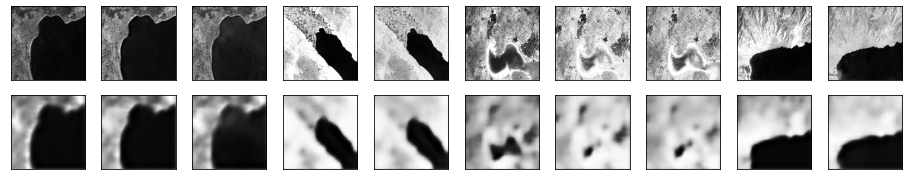

In [67]:
#create a wide (16) and short (3) figure to show 10 images
# and their autoencoded representations stacked top to bottom
plt.figure(figsize=(16, 3))
# loop through 10 sample images
for i in range(10):
    # inputs
    subplot = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    subplot.get_xaxis().set_visible(False) #turn x-axis off
    subplot.get_yaxis().set_visible(False) #turn y-axis off

    # reconstructed inputs
    subplot = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()

> Going Further

Do you think the semantic segmentation task of detecing water pixels would be easier or harder with the coarser detail autoencoder estimates?

On the one hand, it might be easier because there is less extraneous detail preserved from the terrain surrounding the lakes, therefore it might be easier for a model to identify the wet pixels and more reliably distinguish them from the dry pixels.

On the other hand, the loss of detail may also make the lake boundary fuzzy and harder to detect, thereby potentially introducing error in the metrics used to quantify water availability over time. You now have the tools to explore these issues further, by generating datasets based on images in their native resolution and format, versus filtered versions.

#### The U-Net model

Introduced in 2015, the U-Net model is still popular and is also commonly seen embedded in more complex deep learning models

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Encoder: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Decoder: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 

U-Net is symmetrical (hence the "U" in the name) and uses concatenation instead of addition to merge feature maps


#### IoU metric

The intersection over union (IoU) or Jacard metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

The numerator is the number of common pixels, and the denominator is the total number of pixels in the two sets together

In [68]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0] #use the 3d image, not the 4d tensor
    #binarize and make a float
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    # get the intersection (numerator in above equation) 
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    # get the union (denominator)
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    # compute iou as the ratio unless the denominator is zero
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [69]:
# we'll need a few more layers from keras
from tensorflow.keras.layers import Concatenate, Conv2DTranspose

##### Encoder

Downsamples the 512  x 512 x 3 image progressively using six banks of convolutional filters, each using filters double in size to the previous, thereby progressively downsampling the inputs as features are extracted through max pooling

In [70]:
inputs = Input((512, 512, 3))
_tensor = inputs
  
#down sampling 
f = 8 #initially, use an 8-pixel kernel for the convolutional filter
layers = []

#cycle through 6 iterations, each time reusing '_tensor' 
#on each iteration ...
#pass through 2 convolutional blocks, append to the 'layers' output list
#then apply max pooling, and double the filter size for the next iteration
for i in range(0, 6):
   _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
   _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
   layers.append(_tensor)
   _tensor = MaxPooling2D() (_tensor)
   f = f*2
   print(_tensor.shape)

(None, 256, 256, 8)
(None, 128, 128, 16)
(None, 64, 64, 32)
(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 256)


A 'bottleneck' is just machine learning jargon for a very low-dimensional feature representation of a high dimensional input. Or, a relatively small vector of numbers that distill the essential information about a large image

In [71]:
ff2 = 64 ##use an 64-pixel kernel for the convolutional filter
  
#bottleneck 
j = len(layers) - 1
_tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
_tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
_tensor = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_tensor)
# use concatenate to merge feature maps
_tensor = Concatenate(axis=3)([_tensor, layers[j]])
j = j -1 

print(_tensor.shape)

(None, 16, 16, 320)


An input of 512 x 512 x 3 (>780,000 numbers) has been distilled to a 'bottleneck' of 16 x 16 x 320 (<82,000 numbers) 

##### Decoder

Upsamples the bottleneck into a 512  x 512 x 1 label image progressively using six banks of convolutional filters, each using filters half in size to the previous, thereby progressively upsampling the inputs as features are extracted through transpose convolutions and concatenation

In [72]:
#upsampling 
for i in range(0, 5):
  ff2 = ff2//2
  f = f // 2 
  _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
  _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
  _tensor = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_tensor)
  _tensor = Concatenate(axis=3)([_tensor, layers[j]])
  j = j -1 

_tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
_tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)  
_tensor.shape

TensorShape([None, 512, 512, 16])

Transposed convolution?

This relatively new type of deep learning model layer convolves a dilated version of the input tensor, in order to upscale the output. The dilation operation consists of interleaving zeroed rows and columns between each pair of adjacent rows and columns in the input tensor. The dilation rate is the stride length (we use 2 x 2 above) 

Finally, make the classification layer using one final convolutional layers that essentially just maps (by squishing over 16 layers) the output of the previous layer to a single 2D output (with values ranging from 0 to 1) based on a sigmoid activation function

In [73]:
#classification layer
outputs = Conv2D(1, 1, activation='sigmoid') (_tensor)

Make a ```unet``` instance and print a summary to screen

In [74]:
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 512, 512, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 512, 512, 8)  584         conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_8[0][0]                   
_______________________________________________________________________________________

It is a fairly large model with over 6 million parameters

<table style="font-size: 1em; padding: 0; margin: 0;">
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">Deliverable</strong>  
    <br/>The deliverable for Part 3 is a jupyter notebook showing a workflow to set up U-Net models for training using NWPU-RESISC45 lake images and corresponding labels. This will mostly test your understanding of the generic workflow of setting up multiple models for sequential training, in order to evaluate and compare model outputs and ultimately decide which model is best for the task, as well as how to implement custom conditional random fields for refining labels and segmentations in Parts 4 and 5.
    </p>